In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import caffe
import itertools as it
import pandas as pd
import cv2
import scipy
import seaborn
import lmdb
import shutil

from caffe.proto import caffe_pb2
from collections import defaultdict
from math import ceil
from copy import copy
from collections import OrderedDict
from operator import itemgetter, attrgetter
from matplotlib import pyplot
from scipy import ndimage as ndimage
from os.path import join as pjoin

from caffe import layers as L
from caffe import params as P
import tools

from ntb.layer.data import Transformer
from ntb.db import *

from training.util import *

%matplotlib inline
pyplot.rcParams['figure.figsize'] = (10, 6)

In [2]:
SUB_DIR = "ft_softmax_noaug_skiing_adam"

In [3]:
db = NTBDB()

# Data preparation

In [4]:
labels = np.asarray(sorted([
    node.name 
    for node in db.tags.search_nodes(name='skiing')[0].get_descendants()
    if not node.children and len(db.by_tag[node.name]) > 500
]))
for label in labels:
    print label

biathlon
cross-country-skiing
downhill-skiing
freestyle-skiing
giant-slalom
nordic-combined
ski-flying
slalom
snowboarding
super-g


In [5]:
dataset = {
    label: {
        im['filename'] for im in db.by_tag[label]
    }  for label in labels 
}

### Filtering out press-conferences and coaches pictures:

In [6]:
exclude_tags = {u'press-conferences', u'coaches'}
exclude_pics = set(map(itemgetter('filename'), it.chain.from_iterable(db.by_tag[t] for t in exclude_tags)))

In [7]:
excluded_df = {}
for label in dataset:
    before = dataset[label]
    after = before - exclude_pics
    dataset[label] = after
    rate = float(len(before) - len(after))/ len(before)
    excluded_df[label] = round(rate * 100, 2)

excluded_df = pd.DataFrame.from_dict(excluded_df, orient='index').rename(index=str, columns={0: 'excluded %'})

In [8]:
excluded_df.sort_values('excluded %', ascending=False)

,excluded %
cross-country-skiing,7.53
biathlon,6.58
snowboarding,6.54
nordic-combined,3.54
ski-flying,3.20
freestyle-skiing,2.52
slalom,1.14
super-g,0.38
giant-slalom,0.36
downhill-skiing,0.36


### Labels distribution

In [9]:
def plot_distribution(data):
    pic_num_distribution = {
        label: len(imgs) for label, imgs in data.items()
    }
    data = sorted(pic_num_distribution.items(), key=itemgetter(1), reverse=True)
    df = pd.DataFrame.from_dict(OrderedDict(data), orient='index')
    df.plot(kind='bar', legend=False)

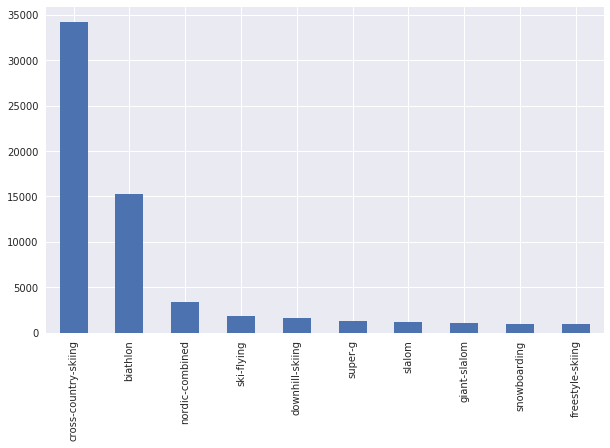

In [29]:
plot_distribution(dataset)

### Reducing imblalance

In [10]:
dataset_balanced = balance_dataset(dataset, limit=10000)
assert all(
    len(imgs - dataset[label]) == 0
    for label, imgs in dataset_balanced.items()
), "Some images are not in the right categories"

In [14]:
float(len(dataset_balanced['cross-country-skiing'])) / sum(map(len, dataset_balanced.values()))

0.3076165866863541

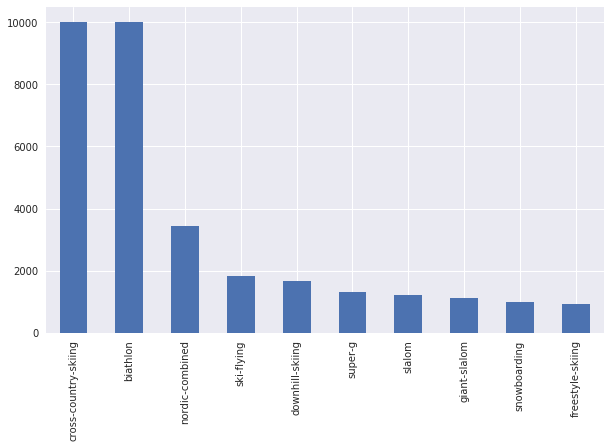

In [33]:
plot_distribution(dataset_balanced)

### Train/Validation/Test dataset split on per category basis

In [34]:
train, rest = split_dataset(dataset_balanced, 0.6)
val, test = split_dataset(rest, 0.5)
assert not set(it.chain.from_iterable(train.values())).intersection(set(it.chain.from_iterable(test.values())))
assert not set(it.chain.from_iterable(train.values())).intersection(set(it.chain.from_iterable(val.values())))
assert not set(it.chain.from_iterable(val.values())).intersection(set(it.chain.from_iterable(test.values())))

### Write sampled dataset to lmdb

In [5]:
data_dir = pjoin(BASE_DIR, 'nets', SUB_DIR, 'data')
train_lmdb = pjoin(data_dir, 'train.lmdb')
val_lmdb = pjoin(data_dir, 'val.lmdb')
mean_image = pjoin(data_dir, 'mean_image.binaryproto')

if not os.path.isdir(data_dir):
    os.makedirs(data_dir)

In [36]:
with open(pjoin(data_dir, 'train_raw.pickle'), mode='w') as f:
    pickle.dump(train, f, protocol=pickle.HIGHEST_PROTOCOL)
with open(pjoin(data_dir, 'val_raw.pickle'), mode='w') as f:
    pickle.dump(val, f, protocol=pickle.HIGHEST_PROTOCOL)
with open(pjoin(data_dir, 'test_raw.pickle'), mode='w') as f:
    pickle.dump(test, f, protocol=pickle.HIGHEST_PROTOCOL)
with open(pjoin(data_dir, 'labels.np'), mode='w') as f:
    labels.dump(f)

In [31]:
def make_datum(img, label):
    return caffe_pb2.Datum(
        channels=3,
        width=227,
        height=227,
        label=label,
        data=np.rollaxis(img, 2).tostring()
    )

def transform_img(img, img_width=227, img_height=227):
    img[:, :, 0] = cv2.equalizeHist(img[:, :, 0])
    img[:, :, 1] = cv2.equalizeHist(img[:, :, 1])
    img[:, :, 2] = cv2.equalizeHist(img[:, :, 2])

    #Image Resizing
    img = cv2.resize(img, (img_width, img_height), interpolation = cv2.INTER_CUBIC)

    return img

In [98]:
def write_lmdb(lmdb_path, indexes, batch_size=1000):
    indexes = np.asarray(list(indexes))
    np.random.shuffle(indexes)
    batch_num = int(ceil(indexes.size/float(batch_size)))
    print "Writing {} images ({} batches) to {}".format(len(indexes), batch_num, lmdb_path)
    with lmdb.open(lmdb_path, map_size=227*227*3*2*indexes.size, writemap=True) as in_db:
        index_lmdb = 0
        for batch_idx, batch in enumerate(np.array_split(indexes, batch_num)):
            with in_db.begin(write=True) as in_txn:
                for index in batch:
                    img = cv2.imread(image_path(db.metadata[index]), cv2.IMREAD_COLOR)
                    img = transform_img(img)
                    for label in labels:
                        if index in dataset[label]:
                            break
                    else:
                        raise ValueError("no label: " + index)
                    label_id = np.where(labels == label)[0][0]
                    datum = make_datum(img, label_id)
                    try:
                        in_txn.put('{:0>5d}'.format(index_lmdb), datum.SerializeToString())
                    except Exception as e:
                        print 'ERROR', index, str(e)
                        raise
                    index_lmdb += 1
                print "batch", batch_idx, "finished"

In [100]:
%%time
shutil.rmtree(train_lmdb, ignore_errors=True)
write_lmdb(train_lmdb, it.chain.from_iterable(train.values()))

Writing 19570 images (20 batches) to /storage/ntb/nets/ft_softmax_noaug_skiing_adam/data/train.lmdb
batch 0 finished
batch 1 finished
batch 2 finished
batch 3 finished
batch 4 finished
batch 5 finished
batch 6 finished
batch 7 finished
batch 8 finished
batch 9 finished
batch 10 finished
batch 11 finished
batch 12 finished
batch 13 finished
batch 14 finished
batch 15 finished
batch 16 finished
batch 17 finished
batch 18 finished
batch 19 finished
CPU times: user 1min 5s, sys: 5.18 s, total: 1min 10s
Wall time: 20min 53s


In [99]:
%%time
shutil.rmtree(val_lmdb, ignore_errors=True)
write_lmdb(val_lmdb, it.chain.from_iterable(val.values()))

Writing 6477 images (7 batches) to /storage/ntb/nets/ft_softmax_noaug_skiing_adam/data/val.lmdb
batch 0 finished
batch 1 finished
batch 2 finished
batch 3 finished
batch 4 finished
batch 5 finished
batch 6 finished
CPU times: user 22.3 s, sys: 1.5 s, total: 23.8 s
Wall time: 4min 53s


In [101]:
%%time
!/work/caffe/build/tools/compute_image_mean -backend=lmdb $train_lmdb $mean_image

CPU times: user 2.94 s, sys: 952 ms, total: 3.9 s
Wall time: 3min 4s


# Training

In [6]:
caffe.set_mode_gpu()

### Create all folders

In [7]:
workdir = pjoin('/storage/ntb/nets', SUB_DIR)
if not os.path.isdir(workdir):
    os.makedirs(workdir)
snapshotsdir = os.path.join(workdir, 'snapshots')
if not os.path.isdir(snapshotsdir):
    os.makedirs(snapshotsdir)

### Setup logging

In [8]:
logs_dir = pjoin(workdir, 'logs')
if not os.path.isdir(logs_dir):
    os.makedirs(logs_dir)
logs_file_path = pjoin(logs_dir, 'train.log')
os.environ['GLOG_log_dir'] = logs_dir
os.environ['GLOG_logbufsecs'] = "1"
caffe.set_log_info(logs_file_path)

### Write nets and solver files

In [9]:
solverprototxt = tools.CaffeSolver(
    trainnet_prototxt_path=os.path.join(workdir, "trainnet.prototxt"),
    testnet_prototxt_path=os.path.join(workdir, "valnet.prototxt"),
)
solverprototxt.sp['solver_mode'] = 'GPU'
solverprototxt.sp['base_lr'] = "0.0001"
solverprototxt.sp['display'] = "1"
solverprototxt.sp['snapshot'] = "200"
solverprototxt.sp['lr_policy'] = '"fixed"'
solverprototxt.sp['test_interval'] = "200"
solverprototxt.sp['test_iter'] = "600"
solverprototxt.sp['max_iter'] = "1000"
solverprototxt.sp['momentum'] = "0.9"
solverprototxt.sp['snapshot_prefix'] = '"{}"'.format(os.path.join(snapshotsdir, 'snapshot'))
solverprototxt.write(os.path.join(workdir, 'solver.prototxt'))

# write train net.
with open(os.path.join(workdir, 'trainnet.prototxt'), 'w') as f:
    f.write(caffenet(
        SUB_DIR, train_lmdb,
        mean_file=mean_image,
        num_labels=labels.size, batch_size=175, include_acc=False
    ))

# write validation net.
with open(os.path.join(workdir, 'valnet.prototxt'), 'w') as f:
    f.write(caffenet(
        SUB_DIR, val_lmdb,
        mean_file=mean_image,
        mirror=False,
        num_labels=labels.size, batch_size=10, include_acc=True
    ))
    
# # write testing net.
# with open(os.path.join(workdir, 'testnet.prototxt'), 'w') as f:
#     f.write(caffenet_multilabel_sigmoid(SUB_DIR, labels.size, is_test=True))

### Load solver

In [10]:
solver = caffe.AdamSolver(os.path.join(workdir, 'solver.prototxt'))

### Start new training

In [11]:
solver.net.copy_from('/models/caffenet/bvlc_reference_caffenet.caffemodel')
solver.test_nets[0].share_with(solver.net)

### Restore from snapshot

In [9]:
for snapshot in sorted(os.listdir(snapshotsdir)):
    if snapshot.endswith('solverstate'):
        print snapshot

snapshot_iter_100.solverstate
snapshot_iter_200.solverstate


In [9]:
solver.restore(os.path.join(snapshotsdir, 'snapshot_iter_200.solverstate'))
solver.test_nets[0].share_with(solver.net)

### Check images and labels

In [37]:
# transformer = Transformer(shape=[227, 227])
# image_index = 3
# pyplot.figure()
# pyplot.imshow(transformer.deprocess(copy(solver.net.blobs['data'].data[image_index, ...])))
# gt = solver.net.blobs['label'].data[image_index, ...].astype(np.int)
# pyplot.title('GT: {}'.format(labels[gt]))
# pyplot.axis('off');

### Train network

In [12]:
solver.solve()

### Rename log file

In [16]:
newest_log = pjoin(logs_dir, max(os.listdir(logs_dir), key=lambda log:  os.path.getctime(pjoin(logs_dir, log))))
print newest_log, '->', logs_file_path
shutil.copyfile(newest_log, logs_file_path)

/storage/ntb/nets/ft_softmax_noaug_skiing_adam/logs/train.log20170304-212025.80 -> /storage/ntb/nets/ft_softmax_noaug_skiing_adam/logs/train.log


### Look at some prediction results

In [ ]:
test_net = solver.test_nets[0]
for image_index in range(20):
    gtlist = test_net.blobs['label'].data[image_index, ...].astype(np.int)
    estlist = test_net.blobs['score'].data[image_index, ...] > 0
    if np.where(estlist)[0].any():
        plt.figure()
        plt.imshow(transformer.deprocess(copy(test_net.blobs['data'].data[image_index, ...])))
        plt.title('GT: {} \n EST: {}'.format(labels[np.where(gtlist)], labels[np.where(estlist)]))
        plt.axis('off')